# CycleGAN: Cycle-Consistent Generative Adversial Networks

*This tutorial introduces the main motivations behind CycleGAN, explains the model's design, teaches you how to implement it on a high-level using TensorFlow, and shows you how to apply to a real-world data science problem.*

### Resources

- Original CycleGAN project repository: https://github.com/junyanz/CycleGAN

- Original GAN paper: https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf

- Tensorflow documentation: https://www.tensorflow.org/programmers_guide/

- Convolutional Neural Networks (CNNs): https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/

- Complete CycleGAN TensorFlow implementation: https://github.com/xhujoy/CycleGAN-tensorflow

### Tutorial Contents
- [Introduction](#1.-Introduction)
- [Implementation](#2.-Implementation)
- [Applications](#3.-Applications)




## 1. Introduction

When designing pipelines to investigate a data science problem in select industries, sometimes the biggest challenge is the preliminary step of obtaining data. Most healthcare providers in the U.S., for example, must abide by the **HIPAA (Health Insurance Portability and Accountability Act) Privacy Rule**, which protects individually identifiable health information. On top of that, there are additional federal and state privacy laws (42 CFR Part 2, Title X of the Public Health Service Act, etc.) that makes amassing large medical datasets extremely difficult and tedious.

Because of this, growing interest in generative deep learning models is driving the research area behind amplifying datasets from an initial source dataset, also known as data augmentation. Specifically, one approach that has gained a lot of traction is the **Generative Adverserial Network (GAN)** because of its high performance accuracy in computer vision applications.

### Generative Models

Most traditional machine learning models such as k-nearest neighbors and logistic regression are **discriminative models** that map input data instances $x$ to output class labels $y$ and attempt to **identify a boundary between classes**. A binary classifier trained to distinguish whether a chest X-ray contains a tumor or not is a good example of a discriminative model.

Behind the scenes, these models achieve that goal by learning a function $h(X)$ that best approximates the underlying oracle function $c(X): X \rightarrow Y$. Discriminative models train on labeled examples (supervised learning) and learn a conditional probability distribution to find $\hat{y}$ such that $\hat{y} = \text{argmax }p(Y=y|x)$.

On the other hand, **generative models** such as Naive Bayes attempt to **model the probability distribution of individual classes** and train on unlabled examples (unsupervised learning). A model that can predict the set of features most likely for  images with and/or without a tumor is an example of a generative model. 

Overall, these models are learning a joint probability distribution $p(x,y)$ that can be used to predict likely $(x,y)$ pairs. Furthermore, the joint distribution can be manipulated using Bayes' Theorem to yield $p(Y=y|x)$, which can be used for classification tasks, and $p(x|Y=y)$, which can be used to predict likely features of a class so it is extremely powerful.

In general, generative models are advantageous because datasets in the real world are rarely labeled since labelling data is often an expensive and tedious process. Additionally, generative models can potentially give us a better understanding of the structure of the input data so the insights gained from training such a model are valuable as well.

### Generative Adverserial Networks (GANs)

First introduced in 2014, GANs are implemented as a system of two neural networks, a generator and an adversary. While the **generator** network produces new data instances (images), the **adversary** classifies them (tumor or no tumor). These predicted labels fuel a double-feedback loop where the generator improves upon its ability to generate more realistic fake data instances and the adversary improves upon its ability to evaluate the authenticity of incoming data instances.

This is analogous to the relationship between a **counterfeiter** and an **inspector**. A counterfeiter aims to produce fake products that will fool the inspector, and upon seeing what the inspector classifies as fake, can make adjustments to improve the production process. On the other hand, the inspector aims to correctly identify the fake products, and will learn from comparing what they know to be real products to improve the classification process.

<img src="gan_model.jpg" width="600">
<br>
<center>*Figure 1: A Generative Adverserial Network*</center>
<center>Source: https://www.analyticsvidhya.com/blog/2017/06/introductory-generative-adversarial-networks-gans/ </center>

**GAN Training Steps:**
1. Train adversary (discriminator) network on the training set of real examples $x \sim p_{data}(x)$
2. Sample from random probability distribution (noise) $z \sim p_{z}(z)$
3. Feed random sample into generator network to produce generated data $G(z)$
4. Feed generated data into discriminator and record predicted labels for real examples $D(x)$ and generated examples $D(G(z))$

### Adverserial Loss

The **GAN objective function** is given by:

<center> $G^* = \underset{G}{\operatorname{argmin}}
\underset{D}{\operatorname{max}}\mathcal{L}_{GAN}(G,D)$ </center><br>
<center>where $\mathcal{L}_{GAN}(G,D)=\mathbb{E}_{x \sim p_{data}(x)}[\text{log}D(x)] + \mathbb{E}_{z \sim p_{z}(z)}[\text{log}(1-D(G(z))]$</center>

In this objective function, the first term represents the probability of the real data sample passing the discriminator and the second term represents the probability of the fake (generated) data sample passing the discriminator. Overall, this metric captures how well the discriminator is able to differentiate the real data from the generated data.

Thus, the discriminator's goal is to maximize this objective function and the generator's goal is to minimize this objective function, giving us the overall GAN objective function $G^*=\underset{G}{\operatorname{argmin}}
\underset{D}{\operatorname{max}}V(D,G)$.

### Cycle-Consistency

GANs, however, face a big problem when applied to unpaired image-to-image translation. In theory, when trained on a large enough dataset GANs can potentially learn mapping $G: X \rightarrow Y$ that maps a set of input images to random permutations of images in target range $Y$, where these permutations are generated from different sampling distributions $p_z(z)$ that correspond to a mapping that's consistent with the target distribution $p_{data}(x)$. Thus, adverserial loss alone isn't enought guarantee that an $x_i$ value will map to specific $y_i$ value.

This is the problem that **CycleGANs** aim to address. The CycleGAN model uses 2 GANs and introduces the constraint of cycle-consistency to push mappings $G:X \rightarrow Y$ and $F:Y \rightarrow X$ to be consistent with each other so that more meaningful translations can be obtained from the model.

These constraints are captured in the follow invariants:
1. $x \in X \approx F(G(x))$ *[Forward consistency]*
2. $y \in Y \approx G(F(y))$ *[Backward consistency]*

<img src="cycle_consistency_loss.png" width="600">

<br>
<center>*Figure 2: Cycle-consistency loss objective function*</center>
<center>Source: https://arxiv.org/pdf/1703.10593.pdf</center>

For establishing forward consistency, distances from the point $\hat{X} = F(G(X))$ from $X$ is used as a loss to improve the mapping $G:X \rightarrow Y$. The same is true for backward consistency and the $F:Y \rightarrow X$ mapping.

This **cycle-consistency loss** objective function is given by:

<center> $\mathcal{L}_{cyc}(G,F) = \mathbb{E}_{x} \sim p_{data}(x)[\|F(G(x))-x\|_1]+\mathbb{E}_{y \sim p_{data}(y)}[\|G(F(y)) - y\|_1]$ </center>

and the overall loss function:

<center>$G^*, F^* = \underset{G,F}{\operatorname{argmin}}
\underset{D_X, D_Y}{\operatorname{max}}\mathcal{L}(G,F,D_X,D_Y)$</center>
<center>where $\mathcal{L}(G,F,D_X,D_Y)=\mathcal{L}_{GAN}(G,D_Y,X,Y)+\mathcal{L}_{GAN}(F,D_X,Y,X)+\lambda \mathcal{L}(G,F)$</center>

In the CycleGAN model, there are 2 GANs that run in parallel. 

The first GAN takes in inputs $x \in X$ and uses that to 1) train the discriminator network $D_X$ and 2) generate an instance of $G(x) \in Y$ through feeding it into the generator. Then, a cyclic instance $F(G(x)) \in X$ is created and cyclic loss $L_{cyc}(x, F(G(x))$ is calculated. This network maintains forward consistency of the CycleGAN, and the other GAN  takes in input $y \in Y$, follows the same steps as outlined above, and maintains backward consistency of the CycleGAN.

<img src="CycleGAN.png" width="600">

<center>*Figure 3: CycleGAN Model*</center>

This model ensures that even in unpaired image-to-image transformations there is a **meaningful relationship** between the input and generated images because each generator must share some features that can be used to map its input images to outputs.

## 2. Implementation

**Disclaimer: ** This is not a full implementation of the CycleGAN model, but rather an outline of the concepts covered in the introduction. The purpose of this section is to give readers an idea of how to design key components of the CycleGAN model and to provide additional explanations of some design choices in the model. A full implementation is beyond the scope of this tutorial, but can be found in the resources above.

In [ ]:
import tensorflow as tf

For the purposes of this tutorial, we will be representing images as inputs of dimension $[256,256,3]$ where the 3 represents the 3 color channels derived from the image's RGB values. 

In addition, let's set some parameters for our model:

In [ ]:
num_gen_filters = num_disc_filters = 64
img_width = 256
img_height = 256
img_depth = 3 # Images have RGB format

### Generator

First we will build the a class representing our generators, which are comprised of 3 main components: encoder, transformer and decoder.

#### Encoder

In the encoding step of the generator, what we're doing is essentially learning the features of an image using a convolutional neural network (CNN). Intuitively, CNNs learn features of an image by examining the spatial relationships between smaller regions by applying kernels (or filters) on the original image. 

For more information about CNNs, check out this blog post: https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/.

Since we are going to be using CNNs for building both our generator and discriminator, it helps to define a general purpose method for creating a CNN layer.

In [ ]:
def conv2d(input_conv, name="conv2d", params=(64, 5, 5, 1, 1)):
    '''
    params: (num features extracted from conv layer, 
             kernel window width, 
             kernel window height, 
             stride (shift) width, 
             stride (shift) height)
    '''
    num_feats, win_width, win_height, str_width, str_height = params
    
    with tf.variable_scope(name):
        conv = tf.nn.conv2d(input_conv, num_feats, [win_width, win_height], [str_width, str_height])

    return conv

We can use this now to build our encoder:

In [ ]:
def encoder(input_img):
    
    conv1 = conv2d(input_img, name="encoder", params=(num_gen_filters, 5, 5, 1, 1))
    # conv1.shape = (256,256,64)
    conv2 = conv2d(conv1, name="encoder", params=(num_gen_filters*2, 3, 3, 2, 2))
    # conv2.shape = (128,128,128)
    conv3 = conv2d(conv2, name="encoder", params=(num_gen_filters*4, 3, 3, 2, 2))
    # conv3.shape = (64,64,256)
    
    return conv3

#### Transformer

In our transformer, we will be taking 256 features vectors of dimensions $[64,64]$ and transforming them into features in the target domain. To do so, we use use resnet blocks, which apply 2 CNN transformations and add the input as a residue to the output layer. This ensures that the characteristics of the original image are not lost in the output.

Below we define the a general function for creating a resnet block:

In [ ]:
def resnet_block(input_res, num_feats):
    
    resnet1 = conv2d(input_res, name="resnet", params=(num_feats, 3, 3, 1, 1))
    resnet2 = conv2d(resnet1, name='resnet', params=(num_feats, 3, 3, 1, 1))
    
    return (input_res + resnet2)

We can use this now to build our transformer, which produces 256 feature vectors in the target domain of size $[64,64]$.

In [ ]:
def transformer(enc_res):
    
    res1 = resnet_block(enc_res, num_feats=num_gen_filters*4)
    res2 = resnet_block(res1, num_feats=num_gen_filters*4)
    res3 = resnet_block(res2, num_feats=num_gen_filters*4)
    res4 = resnet_block(res3, num_feats=num_gen_filters*4)
    res5 = resnet_block(res4, num_feats=num_gen_filters*4)
    res6 = resnet_block(res5, num_feats=num_gen_filters*4)
    # res6.shape = (64,64,256)
    
    return res6

#### Decoder

Very similar in structure to the encoder, the decoder reverses the effects of the encoder to generate an image in our target domain $G(x)$ from its feature vector. From this we will need a deconv layer, which we will also write a general purpose method for here:

In [ ]:
def deconv2d(input_deconv, name="deconv2d", params=(64, 5, 5, 1, 1)):
    
    num_feats, win_width, win_height, str_width, str_height = params
    
    with tf.variable_scope(name):
        deconv = tf.nn.conv2d_transpose(input_deconv, num_feats, [win_width, win_height], [str_width, str_height])
        
    return deconv

We can use this now to build our decoder:

In [ ]:
def decoder(trans_res):
    '''
    params: (num features extracted from conv layer, 
             kernel window width, 
             kernel window height, 
             stride (shift) width, 
             stride (shift) height)
    '''
    deconv1 = deconv2d(trans_res, name="decoder", params=(num_gen_filters*2, 3, 3, 2, 2))
    # deconv1.shape = (128,128,128)
    deconv2 = deconv2d(deconv1, name="decoder", params=(num_gen_filters, 3, 3, 2, 2))
    # deconv2.shape = (256,256,64)
    deconv3 = deconv2d(deconv2, name="decoder", params=(img_depth, 5, 5, 1, 1))
    # deconv3.shape = (256,256,3)
    
    return deconv3

And now we have our overall generator:

In [ ]:
class Generator():
    
    def __init__(self, input_dom, output_dom):
        self.X = input_dom
        self.Y = output_dom
        
    def generate(input_img):
        
        enc_res = encoder(input_img)
        trans_res = transformer(enc_res)
        gen_img = decoder(trans_res)
        
        return gen_img

### Discriminator

Using the general purpose functions above, we can also define our discriminator network, which is simply a series of CNN layers that ultimately reduces the output to 1 dimensional prediction (real/fake).

Here is the discriminator:

In [ ]:
class Discriminator():
    
    def __init__(self, intput_dom, num_feats=4):
        self.X = input_dom
        self.num_feats = num_feats
        
    def discriminate(input_img):
        nf = self.num_feats
        
        conv1 = conv2d(input_img, num_disc_filters, nf, nf, 2, 2)
        conv2 = conv2d(conv1, num_disc_filters*2, nf, nf, 2, 2)
        conv3 = conv2d(conv2, num_disc_filters*4, nf, nf, 2, 2)
        conv4 = conv2d(conv3, num_disc_filters*8, nf, nf, 2, 2)
        result = conv2d(conv4, 1, nf, nf, 1, 1)
        
        return result

### Loss Function

As established earlier, our loss function is key in achieving and understanding the CycleGAN model's goals:

1. Discriminator should correctly classify as many real and generated examples as possible
2. Generators should uphold forward and backward cycle-consistency after applying image-to-image transformations
3. Generators should trick the discriminator as much as possible and lead to incorrect discriminator classifications (maximize error)


#### Discriminator Loss Function

Using a mean-squared error loss function, we can reason about the discriminator's overall loss function by thinking about it as a combination of 2 things: maximizing positive classifications on real images and maximizing negative classifications on generated images. Assuming the convention of 1 as a positive classification and 0 as a negative classification, we are essentially trying to maximize the mean prediction value on reals $mean(input\_X)$ (ie. minimizing $1-mean(input\_X)$). Additionally, we want to minimize the mean prediction value on generated images. This gives us:

In [ ]:
def calc_disc_loss(input_imgs, gen_imgs):
    
    loss1 = tf.reduce_mean(tf.squared_difference(input_imgs, 1))
    loss2 = tf.reduce_mean(tf.squared_difference(gen_imgs, 0))
    
    return (loss1 + loss2) / 2

#### Generator Loss Function

The generator loss function can be broken down similarly. It aims to maximize the other discriminator's loss because the more it fools the other discriminator, the higher that discriminator's loss value. In addition, it aims to minimize the cyclic loss, which captures how far off the original input images are from the results after applying a 2-way mapping on them $F(G(X))$.

In [ ]:
def calc_cycl_loss(input_imgs, cyclic_imgs):
    
    return tf.reduce_mean(tf.abs(input_imgs - cyclic_imgs))
    
def calc_gen_loss(input_imgs, cyclic_imgs, disc_loss_other, cycl_weight=5):
    
    cycl_loss = calc_cycl_loss(input_imgs, cyclic_imgs)
    
    return cycl_weight*cycl_loss + disc_loss_other

Now, we have all the components we need to think about designing the CycleGAN, which will consist of 2 input/output domains, 2 generators and 2 discriminators. Although we won't go into details about how the model loads input data and saves output data, we'll briefly cover how to design its training functionality.

In [ ]:
class CycleGAN():
    
    def __init__(self):
        
        self.G_X = Generator("Y","X")
        self.G_Y = Generator("X","Y")
        self.D_X = Discriminator("X")
        self.D_Y = Discriminator("Y")

    def load_data(dataset_X, dataset_Y):
        
        img_reader = tf.WholeFileReader()
        
        img_X = img_reader.read(dataset_X, img_width, img_height)
        img_Y = img_reader.read(dataset_Y, img_width, img_height)
        
        return img_X, img_Y
        
    def train(self, dataset_X, dataset_Y, epochs=100):
        
        input_X, input_Y = self.load_data(dataset_X, dataset_Y)
        
        with tf.Session() as sess:
            sess.run(init)
        
            for epoch in range(epochs):
                gen_X = self.G_X.generate(input_Y)
                gen_Y = self.G_Y.generate(input_X)

                cyclic_X = self.G_X.generate(gen_Y)
                cyclic_Y = self.G_Y.generate(gen_X)

                disc_X_loss = calc_disc_loss(input_X, gen_X)
                disc_Y_loss = calc_disc_loss(input_Y, gen_Y)

                gen_X_loss = calc_gen_loss(input_X, cyclic_X, disc_Y_loss)
                gen_Y_loss = calc_gen_loss(input_Y, cyclic_Y, disc_X_loss)

                # Update model to minimize these losses

### Optimization

In TensorFlow, optimizers can be bound to specific variables with a minimization objective. Each loss variable in our training procedure can be bound to an optimizer to update the model accordingly as we train more epochs. 

TensorFlow offers many different optimizer subclasses, but here's just one example of such an application:

In [ ]:
learning_rate = 0.5

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

gen_X_trainer = optimizer.minimize(gen_X_loss)
gen_Y_trainer = optimizer.minimize(gen_Y_loss)
disc_X_trainer = optimizer.minimize(disc_X_loss)
disc_Y_trainer = optimizer.minimize(disc_Y_loss)

### Pooling

If we were to calculate the loss functions for each generated image, training would be extremely computationally heavy. To optimize this process, we use something called an **image pool.**

We initially populate the image pool, and after it's full replace a random image from that pool with the next generated sample. This image pool returns a generated image on which discriminator loss is calculated. This is repeated until training is complete.

Below is a method we would add to our CycleGAN class in order to add pooling functionality:

In [ ]:
import random

pool_size = 50

def pooling(self, gen_img):
    
    if (self.num_gen < pool_size):
        
        self.img_pool[self.num_gen] = gen_img
        self.num_gen += 1
        
        return gen_img
    
    else: 
        
        rand_select = random.randint(0, pool_size-1)
        orig_pool_img = self.img_pool[rand_select]
        self.img_pool[rand_select] = gen_img
        
        return orig_pool_img

## 3. Applications

One big upcoming application of CycleGANs is in cancer imaging data. The most successful treatments of patients with cancer have all been characterized by early detection so it is extremely valuable for doctors to be able to identify tumors early and take the necessary action.

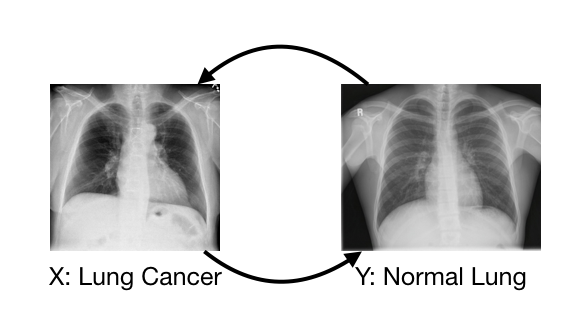

In this example, we apply CycleGANs on chest x-rays to map lungs with tumors to healthy lungs and vice versa. After training the model to converge, we can use it to augment our existing cancerous lung database with more healthy images. This is extremely valuable as sensitive data like this is often hard to obtain and analyze.

In addition, examining the backward generator $F: normal \rightarrow cancerous$ allows to understand what features the model looks for in identifying a cancerous lung.

This approach can be applied across the board to many imaging problems in biology. However, CycleGANs are a very new development (original paper published in Feb. 2018) so its applications are still being explored. But the original paper's results on simple image manipulations have been confirmed in multiple publications since, so the possibility for future application on medical imaging problems are very promising.